In [18]:
import json
import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

import torch

In [19]:
data_dir = '/home/diwu/ralm/self-rag/data_creation/'

gen_data = [json.loads(line) for line in open(data_dir + '/generator_training_data_full_output_1005.jsonl').readlines()]
critic_data = json.load(open(data_dir + '/critic_training_data_gpt4_reward_all_0813_train.json'))

In [20]:
critic_tasks = set([x['task'] for x in critic_data])
critic_task2data = {t: [x for x in critic_data if x['task'] == t] for t in critic_tasks} 
gen_tasks = set([x['task'] for x in critic_data])
gen_task2data = {t: [x for x in critic_data if x['task'] == t] for t in gen_tasks} 

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import numpy as np
from typing import List, Tuple

def jaccard_similarity(str1: str, str2: str) -> float:
    """Calculate the Jaccard Similarity between two strings."""
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def cosine_similarity_with_embedding(documents: List[str], query: str) -> List[Tuple[str, float]]:
    """Calculate cosine similarity using sentence transformer embeddings."""
    model = SentenceTransformer('all-mpnet-base-v2')
    doc_embeddings = model.encode(documents)
    query_embedding = model.encode(query)
    print(doc_embeddings.shape, query_embedding.shape)
    similarities = util.cos_sim(query_embedding, doc_embeddings).squeeze()
    # similarities = cosine_similarity(query_embedding, doc_embeddings).flatten()
    return [(documents[i], similarities[i]) for i in range(len(documents))]

# def top_k_similar_strings(strings: List[str], query: str, k: int, similarity_func) -> List[Tuple[str, float]]:
#     """Return top-k most similar strings based on a similarity function."""
#     similarities = [(string, similarity_func(query, string)) for string in strings]
#     sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
#     return sorted_similarities[:k]

def top_k_similar_strings(strings: List[str], query: str, k: int, similarity_func) -> List[Tuple[str, float]]:
    """Return top-k most similar strings based on a similarity function."""
    similarities = similarity_func(strings, query)
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return sorted_similarities[:k]


# Example usage
inst2entry = {x['input']: x for x in critic_task2data['retrieval']}
strings = [x['input'] for x in critic_task2data['retrieval']]
query = '### Instruction:\nQuestion: Tell me a bio of {entity}.\n\n### Response:\n'
k = 20

# Jaccard similarity
# top_k_jaccard = top_k_similar_strings(strings, query, k, jaccard_similarity)
# print(top_k_jaccard)

# # Cosine similarity (this might take a bit longer due to model loading and embedding computation)
top_k_cosine = top_k_similar_strings(strings, query, k, cosine_similarity_with_embedding)
# print(strings)


(4798, 768) (768,)


In [29]:
[inst2entry[x[0]] for x in top_k_cosine]

[{'instruction': 'When provided with instruction, please evaluate whether seeking additional information from external sources such as the web (e.g., Wikipedia) aids in producing a more comprehensive response. Respond with either [Retrieval] or [No Retrieval].',
  'input': 'Task instruction: Research about a famous scientist and provide a short biography about him/her.\n',
  'output': '[Retrieval]',
  'task': 'retrieval'},
 {'instruction': 'When provided with instruction, please evaluate whether seeking additional information from external sources such as the web (e.g., Wikipedia) aids in producing a more comprehensive response. Respond with either [Retrieval] or [No Retrieval].',
  'input': 'Task instruction: Describe the contents of the given Wikipedia article in one sentence. https://en.wikipedia.org/wiki/Data_visualization\n',
  'output': '[Retrieval]',
  'task': 'retrieval'},
 {'instruction': 'When provided with instruction, please evaluate whether seeking additional information f

In [24]:
# probs = [float(line.strip()) for line in open('/home/diwu/ralm/self-rag/analysis/critic_data_selective_probs_selfrag-7b.txt').readlines()]
prob_outputs = [json.loads(line) for line in open('/home/diwu/ralm/self-rag/analysis/critic_data_selective_probs_selfrag-critic-0105ckpt-4kretrievaldata_reflectiontriggertrue.txt').readlines()]
probs = [torch.exp(torch.tensor(x['ret_token_log_prob'])).item() / (torch.exp(torch.tensor(x['ret_token_log_prob'])).item() + torch.exp(torch.tensor(x['no_ret_token_log_prob'])).item()) for x in prob_outputs]
# print(prob_outputs[0])
# probs = [float(line.strip()) for line in open('/home/diwu/ralm/self-rag/analysis/critic_data_selective_probs_selfrag-critic-0105ckpt-4kretrievaldata_reflectiontriggertrue.txt').readlines()]

print(len(probs))
entries = list(zip(probs, critic_task2data['retrieval']))


4798


In [25]:

retrieval_entries = [x for x in entries if x[1]['output'] == '[Retrieval]']
no_retrieval_entries = [x for x in entries if x[1]['output'] == '[No Retrieval]']

print('T\tP\tR\tF1')
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    precision_count, precision_all = 0, 0
    recall_count, recall_all = 0, 0
    for score, entry in entries:
        if entry['output'] == '[Retrieval]':
            recall_all += 1
            if score > threshold:
                recall_count += 1
        if score > threshold:
            precision_all += 1
            if entry['output'] == '[Retrieval]':
                precision_count += 1

    precision = precision_count / precision_all if precision_all != 0 else 0
    recall = recall_count / recall_all if recall_all != 0 else 0
    f1 = ((2 * precision * recall) / (precision + recall)) if precision * recall != 0 else 0 
    
    # no_retrieval_acc = len([x for x in no_retrieval_entries if x[0] <= threshold]) / len(no_retrieval_entries)
    # retrieval_acc = len([x for x in retrieval_entries if x[0] > threshold]) / len(retrieval_entries)
    # print('{} {:.04f} {:.04f}'.format(threshold, no_retrieval_acc, retrieval_acc))

    
    print('{}\t{:.04f}\t{:.04f}\t{:.04f}'.format(threshold, precision, recall, f1))

T	P	R	F1
0.1	0.4931	1.0000	0.6605
0.2	0.6136	0.9569	0.7477
0.3	0.7871	0.8483	0.8165
0.4	0.8237	0.8039	0.8137
0.5	0.8442	0.7718	0.8064
0.6	0.8571	0.7553	0.8030
0.7	0.8754	0.7367	0.8001
0.8	0.9519	0.5270	0.6785
0.9	0.0000	0.0000	0.0000


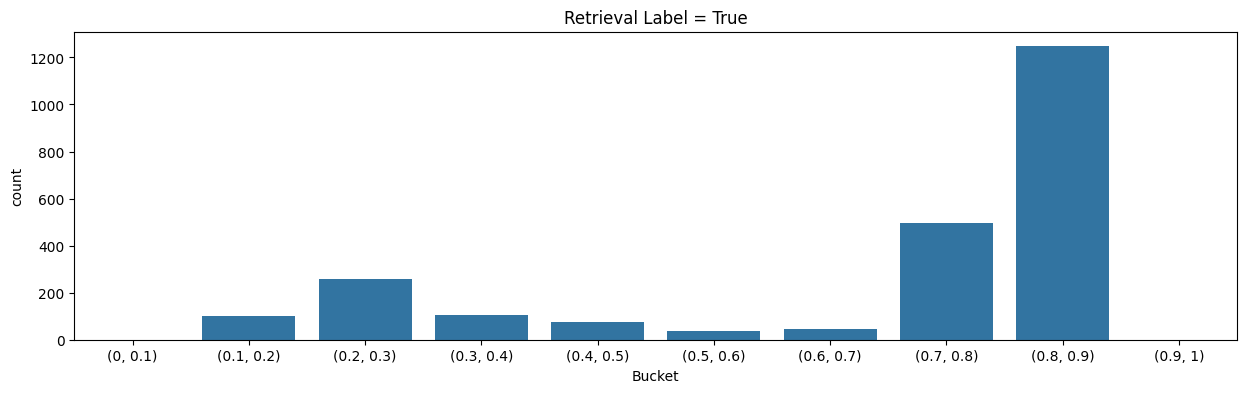

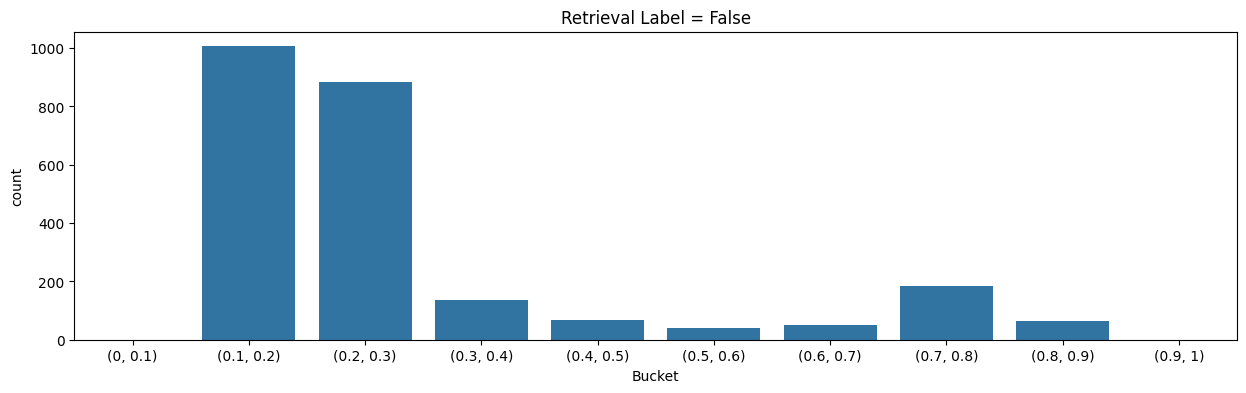

In [26]:
# group into buckets
def plot_score_distribution_v3(values, ranges, exp_name, out_dir):
    def bucket_value(val, ranges):
        try:
            _ = ranges[0]
            for start, end in ranges:
                if start <= val < end:
                    if end == -0.01:
                        return f"({start}, 0)"
                    if start == -0.01:
                        return "0"
                    if start == 0.01:
                        return f"(0, {end})"
                    return f"({start}, {end})"
            return f"({end}+)"
        except:
            for x in ranges:
                if x == val:
                    return f"{x}"
            return "others"

    df = pd.DataFrame(values, columns=["Value"])
    df["Bucket"] = df["Value"].apply(bucket_value, ranges=ranges)

    try:
        order = [f"({start}, {end})" for start, end in ranges] # + [f"({ranges[-1][1]}+)"]
    except:
        order = [f"{x}" for x in ranges] + ["others"]

    order_corrected = []
    for start, end in ranges:
        if end == -0.01:
            order_corrected.append(f"({start}, 0)")
        elif start == -0.01:
            order_corrected.append("0")
        elif start == 0.01:
            order_corrected.append(f"(0, {end})")
        else:
            order_corrected.append(f"({start}, {end})")

    plt.figure(figsize=(15, 4))
    sns.countplot(data=df, x="Bucket", order=order_corrected)
    plt.title(exp_name)
    plt.show()

plot_score_distribution_v3([x[0] for x in retrieval_entries],
                           [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)], 
                           'Retrieval Label = True', "")
plot_score_distribution_v3([x[0] for x in no_retrieval_entries],
                           [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)], 
                           'Retrieval Label = False', "")

In [85]:
binary_preds = [line.strip() for line in open('/home/diwu/ralm/self-rag/analysis/critic_data_greedy_selfrag-critic-0105ckpt-4kretrievaldata_reflectiontriggertrue.txt').readlines()]
entries = list(zip(binary_preds, critic_task2data['retrieval']))

acc = []
tp, fp, tn, fn = 0, 0, 0, 0
confusion_instances = {'tp': [], 'fp': [], 'tn': [], 'fn': []}
for pred, entry in entries:
    if entry['output'] == pred:
        acc.append(1)
    else:
        acc.append(0)

    if entry['output'] == '[Retrieval]' and pred == '[Retrieval]':
        tp += 1
        confusion_instances['tp'].append(entry)
    elif entry['output'] == '[Retrieval]' and pred != '[Retrieval]':
        fn += 1
        confusion_instances['fn'].append(entry)
    elif entry['output'] != '[Retrieval]' and pred == '[Retrieval]':
        fp += 1
        confusion_instances['fp'].append(entry)
    else:
        tn += 1
        confusion_instances['tn'].append(entry)
        
print(np.mean(acc))
print(Counter(binary_preds))
# tp, fp, tn, fn = tp/len(acc), fp/len(acc), tn/len(acc), fn/len(acc)
print(f'tp={tp}, fp={fp}, tn={tn}, fn={fn}')
print(f'p={tp/(tp+fp)}, r={tp/(tp+fn)}')

0.8172155064610255
Counter({'[No Retrieval]': 2635, '[Retrieval]': 2163})
tp=1826, fp=337, tn=2095, fn=540
p=0.8441978733240869, r=0.7717666948436179


In [76]:

# plot_score_distribution_v3([len(x['input'].split()) for _, x in retrieval_entries],
#                            [(1, 3), (3,6), (6,9), (9, 12), (12, 15), (15, 18), (18,21), (21, 24), (24, 27), (27, 30), (30, 33), (33, 36), (36, 39), (39,42)], 
#                            'Sentence length distribution for Retrieval Label = True', "")

# plot_score_distribution_v3([len(x['input'].split()) for _, x in no_retrieval_entries],
#                            [(1, 3), (3,6), (6,9), (9, 12), (12, 15), (15, 18), (18,21), (21, 24), (24, 27), (27, 30), (30, 33), (33, 36), (36, 39), (39,42)], 
#                            'Sentence length distribution for Retrieval Label = False', "")

In [71]:
def has_more_than_one(s):
    if '[Retrieval]' in s and '[No Retrieval]' in s:
        return True
    if '[Retrieval]' in s and '[Continue to Use Evidence]' in s:
        return True
    if '[Continue to Use Evidence]' in s and '[No Retrieval]' in s:
        return True
    return False

gen_id2data = {x['id']: x for x in gen_data}
dataset_names = set([x['dataset_name'] for x in gen_data])
print(Counter([x['dataset_name'] for x in gen_data]))
print('Retrieval label distribution')
for ds_name in dataset_names:
    print(ds_name)
    ds_subset = [x for x in gen_data if x['dataset_name'] == ds_name]
    retrieval_count = len([x for x in ds_subset if '[Retrieval]' in x['output']])
    no_retrieval_count = len([x for x in ds_subset if '[No Retrieval]' in x['output']])
    continue_count = len([x for x in ds_subset if '[Continue to Use Evidence]' in x['output']])
    multi_count = len([x for x in ds_subset if has_more_than_one(x['output'])])
    # print(f"\t{retrieval_count/len(ds_subset):.04f} RET\t{no_retrieval_count/len(ds_subset):.04f} NO RET\t{continue_count/len(ds_subset):.04f} CONT\t{multi_count/len(ds_subset):.04f} mixture")
    print(f"\t{retrieval_count/len(ds_subset):.04f} RET\t{continue_count/len(ds_subset):.04f} CONT\t{multi_count/len(ds_subset):.04f} mixture")
    


Counter({'gpt4_alpaca': 26168, 'stanford_alpaca': 25153, 'flan_v2': 17817, 'wow': 17367, 'nq': 15535, 'sharegpt': 13406, 'fever': 9966, 'oasst1': 9464, 'obqa': 4699, 'asqa': 3897, 'arc_easy': 2147})
Retrieval label distribution
flan_v2
	0.1586 RET	0.0294 CONT	0.0723 mixture
sharegpt
	0.7683 RET	0.1351 CONT	0.6720 mixture
nq
	0.8771 RET	0.0001 CONT	0.0004 mixture
gpt4_alpaca
	0.5329 RET	0.1488 CONT	0.4029 mixture
wow
	0.2266 RET	0.0873 CONT	0.2064 mixture
asqa
	0.9153 RET	0.4455 CONT	0.5635 mixture
oasst1
	0.7709 RET	0.1461 CONT	0.5714 mixture
fever
	0.6323 RET	0.0000 CONT	0.0000 mixture
obqa
	0.0228 RET	0.0000 CONT	0.0000 mixture
stanford_alpaca
	0.4803 RET	0.0720 CONT	0.2226 mixture
arc_easy
	0.1095 RET	0.0000 CONT	0.0000 mixture
